In [524]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [525]:
def f(x):
    return 3*x**2 - 4*x +5

In [526]:
f(3)

20

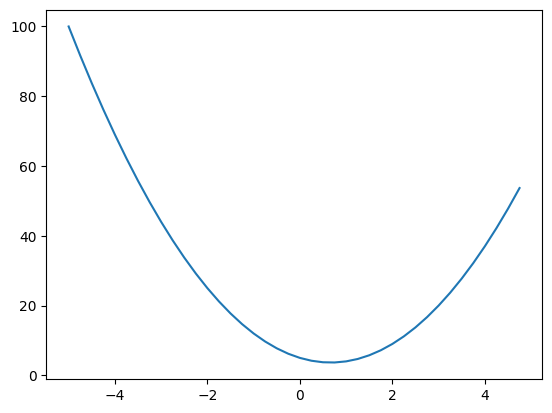

In [527]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [528]:
h = 0.0001
x = 3
(f(x+h) - f(x)) / h

14.000300000063248

In [529]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
d

4.0

In [530]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+c
b += h
d2 = a*b+c

d1, d2, (d2-d1)/h

(4.0, 4.0002, 2.0000000000042206)

In [531]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [532]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, n):
        self.neurons = [Neuron(nin) for _ in range(n)]
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
class MLP:
    def __init__(self, nins, nouts):
        sz = [nins] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [533]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7995507520970213)

In [534]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [535]:
for k in range(25):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  for p in n.parameters():
    p.data += -0.5 * p.grad
  print(k, loss.data)


0 3.9349294605104985
1 7.140948637433647
2 4.748925721898951
3 3.9263440017361586
4 0.9485915648013991
5 0.22947782302606123
6 0.07774572679664199
7 0.06203818291856383
8 0.051643013245869764
9 0.04419022814137863
10 0.03857082548730146
11 0.03418012887332498
12 0.03065573148793209
13 0.02776576758433425
14 0.025354511823180333
15 0.023313332262134816
16 0.02156408506904569
17 0.02004910499484234
18 0.018724908634409572
19 0.017558090925812307
20 0.016522569942358047
21 0.015597688915080857
22 0.01476687925047487
23 0.0140167000290565
24 0.013336135813436241
25 0.012716075207006771
26 0.012148918139423336
27 0.011628276296260426
28 0.0111487419238864
29 0.010705707490762722
30 0.010295223632765586
31 0.009913886238842833
32 0.009558745944895293
33 0.009227235022844938
34 0.008917107892560635
35 0.008626392390110314
36 0.008353349594208831
37 0.008096440510883025
38 0.007854298291124374
39 0.007625704940681974
40 0.007409571698735331
41 0.007204922429953959
42 0.007010879504752301
43 0.

In [537]:
y_pred = [n(x).data for x in xs]
y_pred

[0.9983238262227728,
 -0.9981587583600653,
 -0.9969880688297079,
 0.9974205325267982]